#**스마트폰 센서 데이터 기반 모션 분류**
# 단계1 : 탐색적 데이터 분석

### (1) 경로 설정

* 구글 드라이브 연결

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = '/content/drive/MyDrive/project3/'

### (2) 라이브러리 설치 및 불러오기

* 라이브러리 로딩

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import joblib

from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from sklearn.ensemble import RandomForestClassifier

In [ ]:
# 변수의 특성 중요도 계산하기
def plot_feature_importance(importance, names, result_only = False, topn = 'all'):
    feature_importance = np.array(importance)
    feature_name = np.array(names)

    data={'feature_name':feature_name,'feature_importance':feature_importance}
    fi_temp = pd.DataFrame(data)

    #변수의 특성 중요도 순으로 정렬하기
    fi_temp.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    fi_temp.reset_index(drop=True, inplace = True)

    if topn == 'all' :
        fi_df = fi_temp.copy()
    else :
        fi_df = fi_temp.iloc[:topn]

    #변수의 특성 중요도 그래프로 그리기
    if result_only == False :
        plt.figure(figsize=(10,20))
        sns.barplot(x='feature_importance', y='feature_name', data = fi_df)

        plt.xlabel('importance')
        plt.ylabel('feature name')
        plt.grid()

    return fi_df

### (3) 데이터 불러오기

In [ ]:
file1 = 'data01_train.csv'
file2 = 'data01_test.csv'
file3 = 'features.csv'

In [ ]:
data = pd.read_csv(path + file1)
test = pd.read_csv(path + file2)
features = pd.read_csv(path + file3)

In [ ]:
# 불필요한 칼럼 삭제
data.drop('subject', axis=1, inplace=True)
test.drop('subject', axis=1, inplace=True)

## 2.데이터 분석 : 기본정보 살펴보기

### (1) 기본정보 확인하기


In [ ]:
#전체 데이터의 행,열 개수 확인
data.shape

(5881, 562)

In [ ]:
#전체 데이터의 상위 5개 행 확인
data.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",Activity
0,0.288508,-0.009196,-0.103362,-0.988986,-0.962797,-0.967422,-0.989000,-0.962596,-0.965650,-0.929747,...,-0.487737,-0.816696,-0.042494,-0.044218,0.307873,0.072790,-0.601120,0.331298,0.165163,STANDING
1,0.265757,-0.016576,-0.098163,-0.989551,-0.994636,-0.987435,-0.990189,-0.993870,-0.987558,-0.937337,...,-0.237820,-0.693515,-0.062899,0.388459,-0.765014,0.771524,0.345205,-0.769186,-0.147944,LAYING
2,0.278709,-0.014511,-0.108717,-0.997720,-0.981088,-0.994008,-0.997934,-0.982187,-0.995017,-0.942584,...,-0.535287,-0.829311,0.000265,-0.525022,-0.891875,0.021528,-0.833564,0.202434,-0.032755,STANDING
3,0.289795,-0.035536,-0.150354,-0.231727,-0.006412,-0.338117,-0.273557,0.014245,-0.347916,0.008288,...,-0.004012,-0.408956,-0.255125,0.612804,0.747381,-0.072944,-0.695819,0.287154,0.111388,WALKING
4,0.394807,0.034098,0.091229,0.088489,-0.106636,-0.388502,-0.010469,-0.109680,-0.346372,0.584131,...,-0.157832,-0.563437,-0.044344,-0.845268,-0.974650,-0.887846,-0.705029,0.264952,0.137758,WALKING_DOWNSTAIRS


In [ ]:
#전체 데이터의 수치형 변수 분포 확인
data.describe()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-meanFreq(),fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)"
count,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,...,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000
mean,0.274811,-0.017799,-0.109396,-0.603138,-0.509815,-0.604058,-0.628151,-0.525944,-0.605374,-0.465490,...,0.126955,-0.305883,-0.623548,0.008524,-0.001185,0.009340,-0.007099,-0.491501,0.059299,-0.054594
std,0.067614,0.039422,0.058373,0.448807,0.501815,0.417319,0.424345,0.485115,0.413043,0.544995,...,0.249176,0.322808,0.310371,0.339730,0.447197,0.608190,0.476738,0.509069,0.297340,0.278479
min,-0.503823,-0.684893,-1.000000,-1.000000,-0.999844,-0.999667,-1.000000,-0.999419,-1.000000,-1.000000,...,-0.965725,-0.979261,-0.999765,-0.976580,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-0.980143
25%,0.262919,-0.024877,-0.121051,-0.992774,-0.977680,-0.980127,-0.993602,-0.977865,-0.980112,-0.936067,...,-0.021610,-0.541969,-0.845985,-0.122361,-0.294369,-0.481718,-0.373345,-0.811397,-0.018203,-0.141555
50%,0.277154,-0.017221,-0.108781,-0.943933,-0.844575,-0.856352,-0.948501,-0.849266,-0.849896,-0.878729,...,0.133887,-0.342923,-0.712677,0.010278,0.005146,0.011448,-0.000847,-0.709441,0.182893,0.003951
75%,0.288526,-0.010920,-0.098163,-0.242130,-0.034499,-0.262690,-0.291138,-0.068857,-0.268539,-0.013690,...,0.288944,-0.127371,-0.501158,0.154985,0.285030,0.499857,0.356236,-0.511330,0.248435,0.111932
max,1.000000,1.000000,1.000000,1.000000,0.916238,1.000000,1.000000,0.967664,1.000000,1.000000,...,0.946700,0.989538,0.956845,1.000000,1.000000,0.998702,0.996078,0.977344,0.478157,1.000000


In [ ]:
#전체 데이터의 모든 변수 확인
data.columns

Index(['tBodyAcc-mean()-X', 'tBodyAcc-mean()-Y', 'tBodyAcc-mean()-Z',
       'tBodyAcc-std()-X', 'tBodyAcc-std()-Y', 'tBodyAcc-std()-Z',
       'tBodyAcc-mad()-X', 'tBodyAcc-mad()-Y', 'tBodyAcc-mad()-Z',
       'tBodyAcc-max()-X',
       ...
       'fBodyBodyGyroJerkMag-skewness()', 'fBodyBodyGyroJerkMag-kurtosis()',
       'angle(tBodyAccMean,gravity)', 'angle(tBodyAccJerkMean),gravityMean)',
       'angle(tBodyGyroMean,gravityMean)',
       'angle(tBodyGyroJerkMean,gravityMean)', 'angle(X,gravityMean)',
       'angle(Y,gravityMean)', 'angle(Z,gravityMean)', 'Activity'],
      dtype='object', length=562)

### (2) 목표 변수 확인하기

In [ ]:
# 범주별 빈도수
data['Activity'].value_counts()

,count
Activity,
LAYING,1115
STANDING,1087
SITTING,1032
WALKING,998
WALKING_UPSTAIRS,858
WALKING_DOWNSTAIRS,791


In [ ]:
# 범주별 비율
data['Activity'].value_counts() / data.shape[0]

,count
Activity,
LAYING,0.189594
STANDING,0.184833
SITTING,0.175480
WALKING,0.169699
WALKING_UPSTAIRS,0.145894
WALKING_DOWNSTAIRS,0.134501


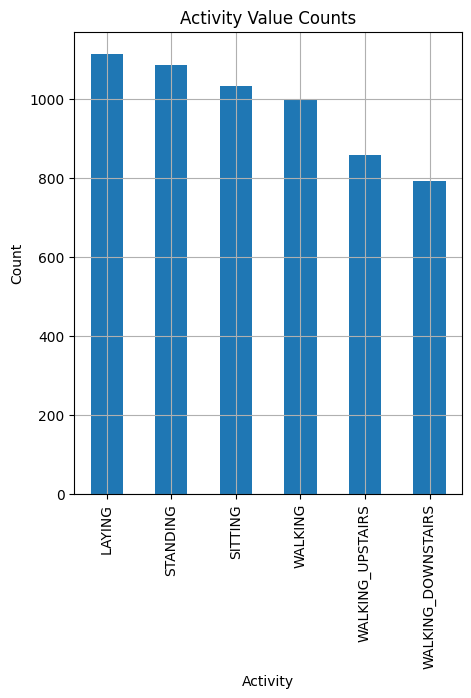

In [ ]:
activity_counts = data['Activity'].value_counts()

# 시각화
plt.figure(figsize=(5, 6))
activity_counts.sort_values(ascending=False).plot(kind='bar')
plt.title('Activity Value Counts')
plt.xlabel('Activity')
plt.ylabel('Count')
plt.grid()
plt.show()


## 3.미션1 : 데이터 분석1

### (1) 기본모델링 + 변수중요도 추출

#### 1) 데이터 전처리

In [ ]:
# 데이터 분할을 위한 전처리
target = 'Activity'
x = data.drop(target, axis = 1)
y = data.loc[:, target]

x_train, x_val, y_train, y_val = train_test_split(x, y, test_size = .3, random_state=1)

#### 2) 모델링

In [ ]:
#생성
model = RandomForestClassifier()

#학습
model.fit(x_train, y_train)
pred = model.predict(x_val)

#평가
print('accuracy :',accuracy_score(y_val, pred))
print('='*60)
print(confusion_matrix(y_val, pred))
print('='*60)
print(classification_report(y_val, pred))

accuracy : 0.9779036827195468
[[330   0   0   0   0   1]
 [  0 281  11   0   0   0]
 [  0  15 316   0   0   0]
 [  0   0   0 292   2   3]
 [  0   0   0   1 234   4]
 [  0   0   0   0   2 273]]
                    precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       331
           SITTING       0.95      0.96      0.96       292
          STANDING       0.97      0.95      0.96       331
           WALKING       1.00      0.98      0.99       297
WALKING_DOWNSTAIRS       0.98      0.98      0.98       239
  WALKING_UPSTAIRS       0.97      0.99      0.98       275

          accuracy                           0.98      1765
         macro avg       0.98      0.98      0.98      1765
      weighted avg       0.98      0.98      0.98      1765



#### 3) 변수 중요도 추출

,feature_name,feature_importance
0,tGravityAcc-min()-X,0.033881
1,tGravityAcc-mean()-Y,0.030443
2,"angle(X,gravityMean)",0.030038
3,tGravityAcc-mean()-X,0.028891
4,tGravityAcc-min()-Y,0.028681
...,...,...
556,"fBodyAcc-bandsEnergy()-57,64.1",0.000090
557,fBodyBodyGyroJerkMag-mad(),0.000084
558,fBodyAcc-min()-Z,0.000081
559,"fBodyAcc-bandsEnergy()-33,40.1",0.000065


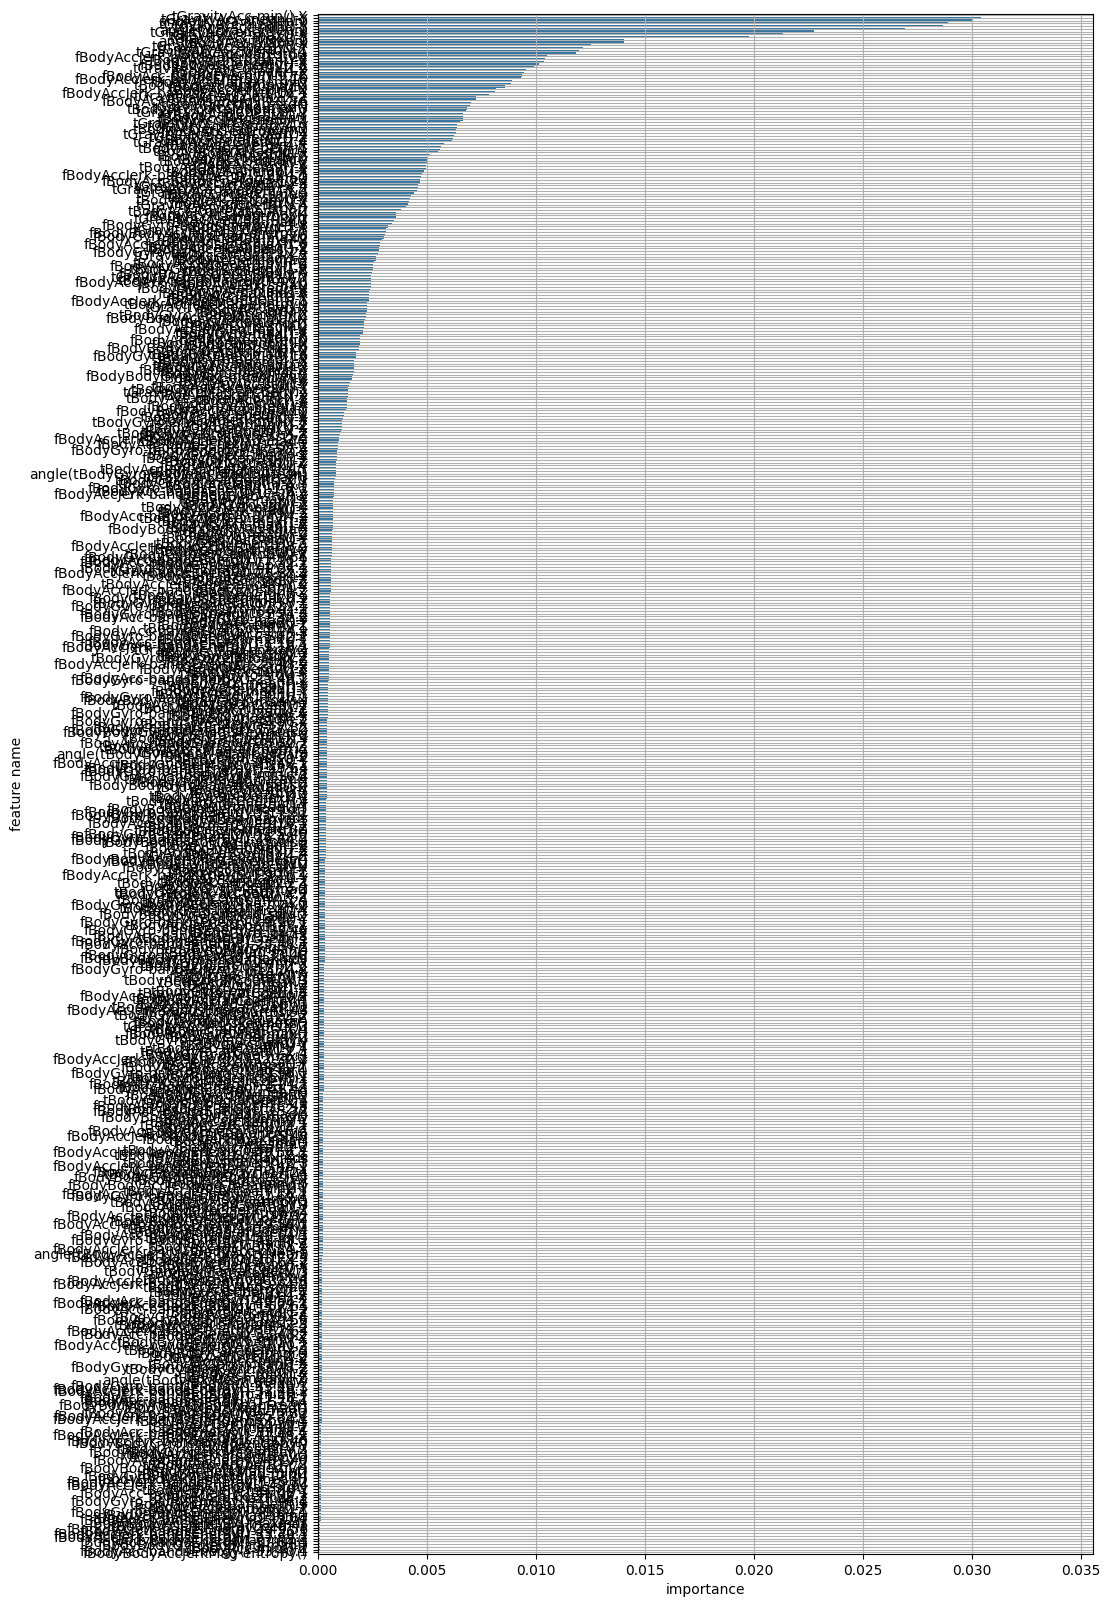

In [ ]:
# 변수 중요도 추출
r0 = plot_feature_importance(model.feature_importances_, list(x_train), False)
r0

### (2) 중요도 기반 feature 분석

#### 1) 상위 5, 하위 5개 변수 선정

In [ ]:
# 중요도 상위 5개
top_5 = r0['feature_name'].head(5).tolist()
top_5

['tGravityAcc-min()-X',
 'tGravityAcc-mean()-Y',
 'angle(X,gravityMean)',
 'tGravityAcc-mean()-X',
 'tGravityAcc-min()-Y']

In [ ]:
# 중요도 하위 5개
bottom_5 = r0['feature_name'].tail(5).tolist()
bottom_5

['fBodyAcc-bandsEnergy()-57,64.1',
 'fBodyBodyGyroJerkMag-mad()',
 'fBodyAcc-min()-Z',
 'fBodyAcc-bandsEnergy()-33,40.1',
 'fBodyBodyAccJerkMag-entropy()']

#### 2) 상위 5개 변수에 대한 분석

In [ ]:
# 각 변수를 반복하며 KDE plot을 생성
def plot_top_features_kde(features, data, hue_col=target):
    plt.figure(figsize=(20, 15))  # 전체 plot의 크기 설정
    for i, feature in enumerate(features, 1):
        plt.subplot(3, 2, i)  # 3x2 grid 형태로 subplot 배치
        sns.kdeplot(x=feature, data=data, hue=hue_col, fill=True, common_norm=False)
        plt.title(f'KDE Plot: {feature} by {hue_col}')
        plt.xlabel(feature)
        plt.ylabel('Density')
    plt.tight_layout()  # 레이아웃 조정
    plt.show()

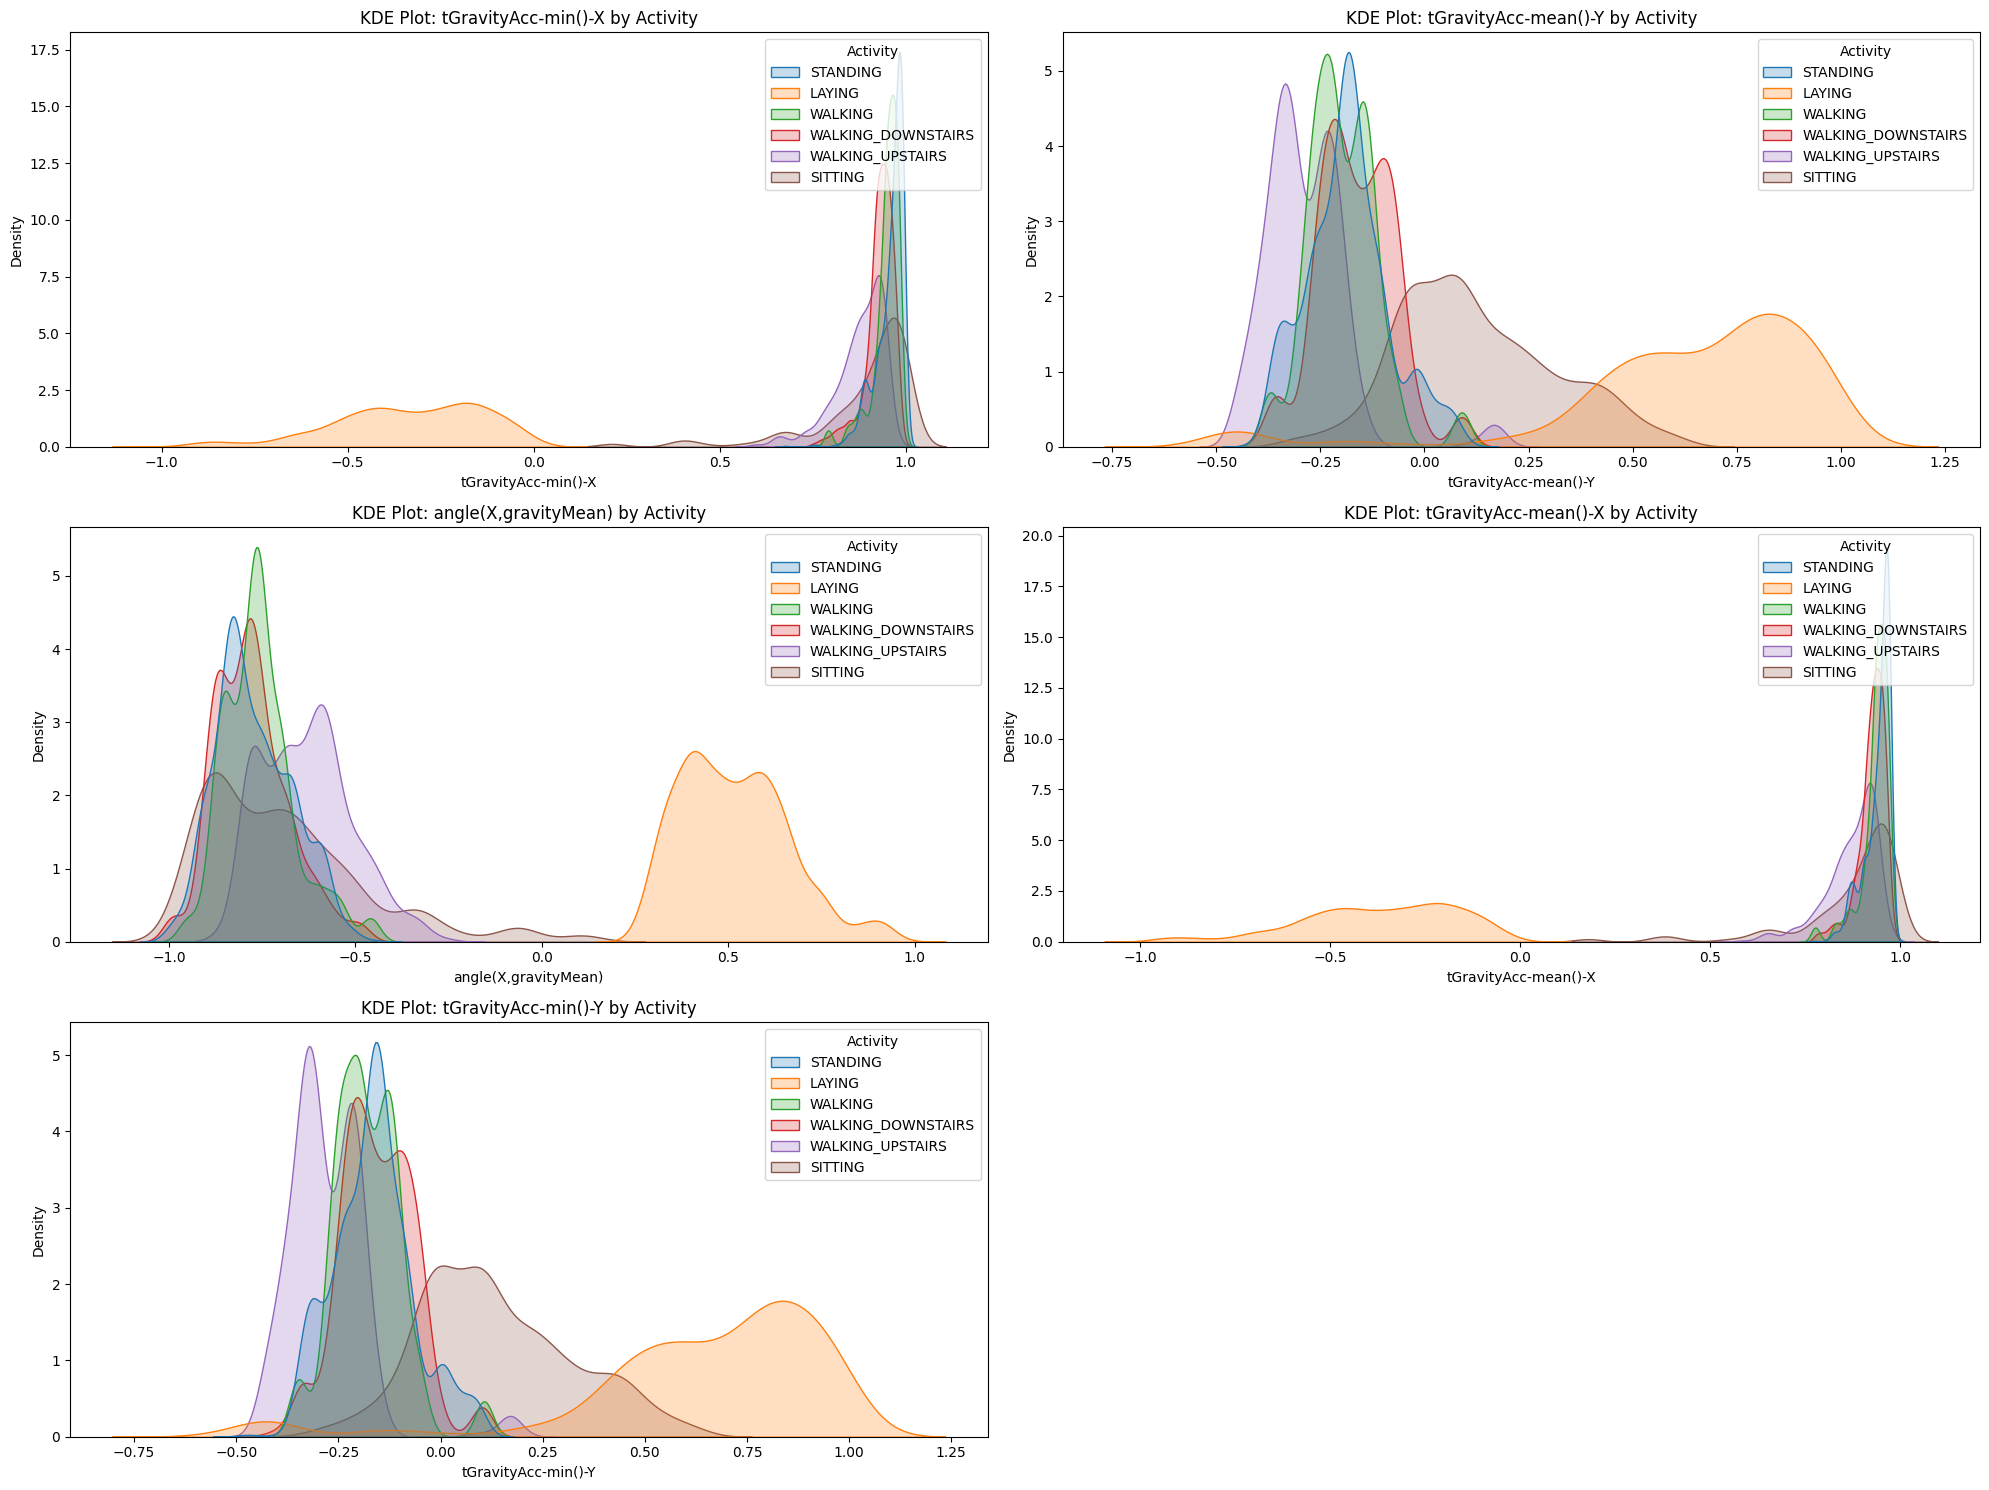

In [ ]:
#상위 5개 feature를 시각화
plot_top_features_kde(top_5, data)

#### 3) 하위 5개 변수에 대한 분석

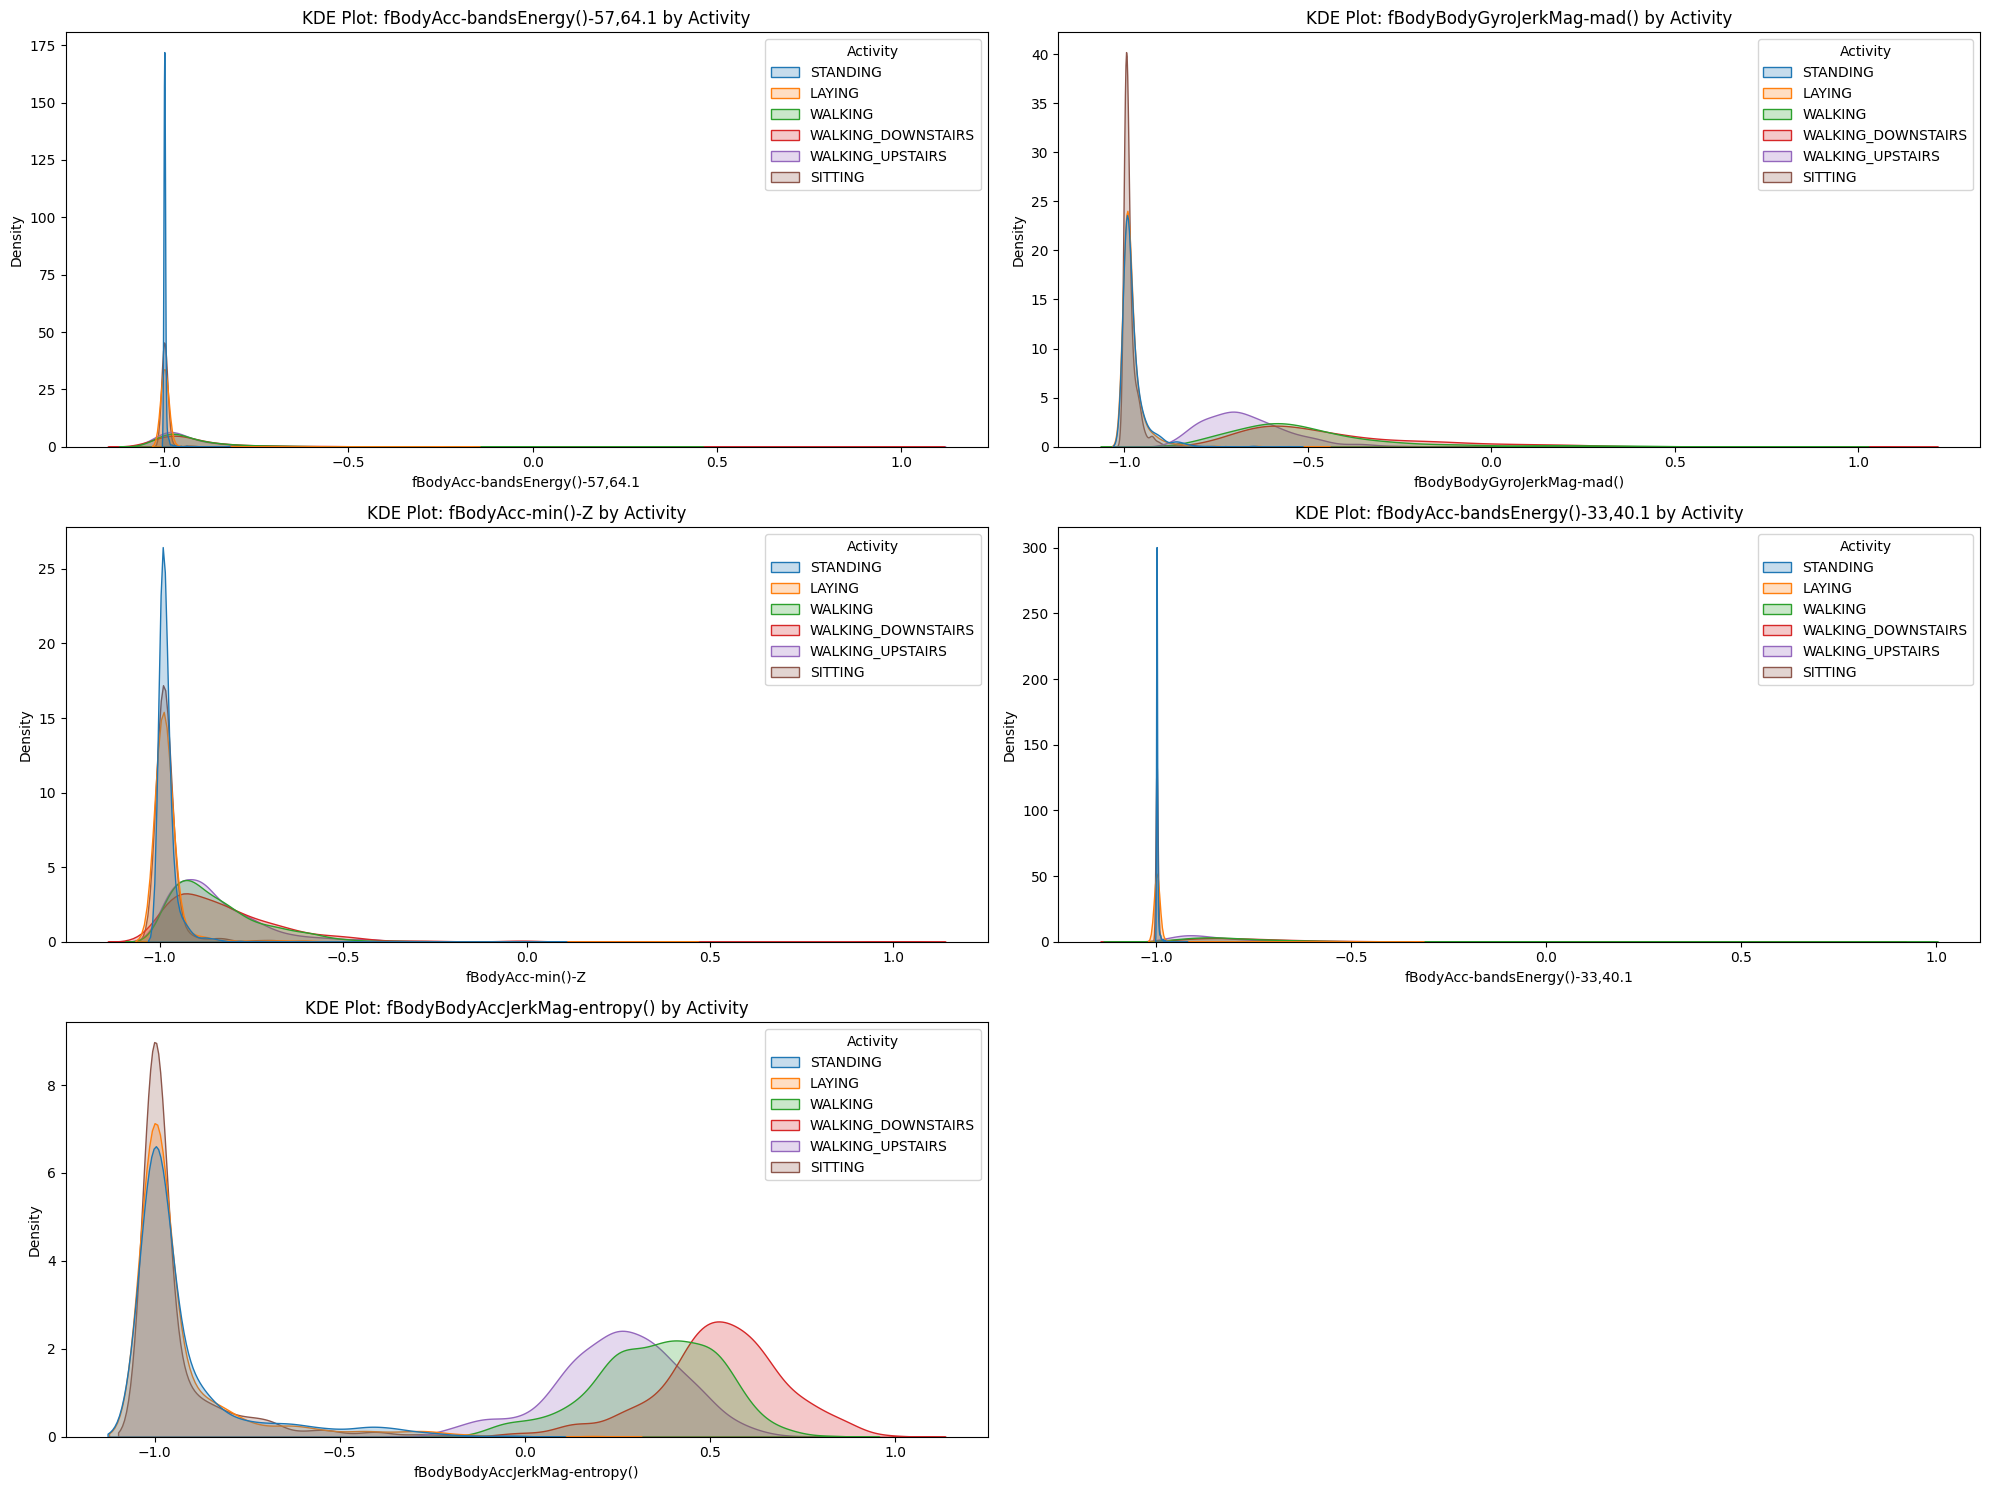

In [ ]:
#하위 5개 feature를 시각화
plot_top_features_kde(bottom_5, data)

## 4.미션2 : 데이터 분석2

### (1) 정적/동적 행동으로 구분하여 분석하기

#### 1) is_dynamic 추가

In [ ]:
is_dynamic = y.map({'STANDING':0, 'SITTING':0, 'LAYING':0,
                  'WALKING':1, 'WALKING_UPSTAIRS':1, 'WALKING_DOWNSTAIRS':1})
is_dynamic

,Activity
0,0
1,0
2,0
3,1
4,1
...,...
5876,0
5877,1
5878,0
5879,1


#### 2) 기본모델 생성

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(x, is_dynamic, test_size = .3)

In [ ]:
model = RandomForestClassifier()
model.fit(x_train, y_train)
pred = model.predict(x_val)

print('accuracy :',accuracy_score(y_val, pred))
print('='*60)
print(confusion_matrix(y_val, pred))
print('='*60)
print(classification_report(y_val, pred))

accuracy : 1.0
[[950   0]
 [  0 815]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       950
           1       1.00      1.00      1.00       815

    accuracy                           1.00      1765
   macro avg       1.00      1.00      1.00      1765
weighted avg       1.00      1.00      1.00      1765



#### 3) 변수중요도 상위 5개 분석

,feature_name,feature_importance
0,tBodyAccJerk-energy()-X,0.059901
1,"fBodyAccJerk-bandsEnergy()-9,16",0.049774
2,tBodyAccJerk-iqr()-X,0.040064
3,tBodyAccJerk-mad()-X,0.039833
4,"fBodyAccJerk-bandsEnergy()-1,16",0.030039
...,...,...
556,tBodyGyroMag-entropy(),0.000000
557,tBodyGyroMag-iqr(),0.000000
558,tBodyGyroMag-energy(),0.000000
559,tBodyGyroMag-sma(),0.000000


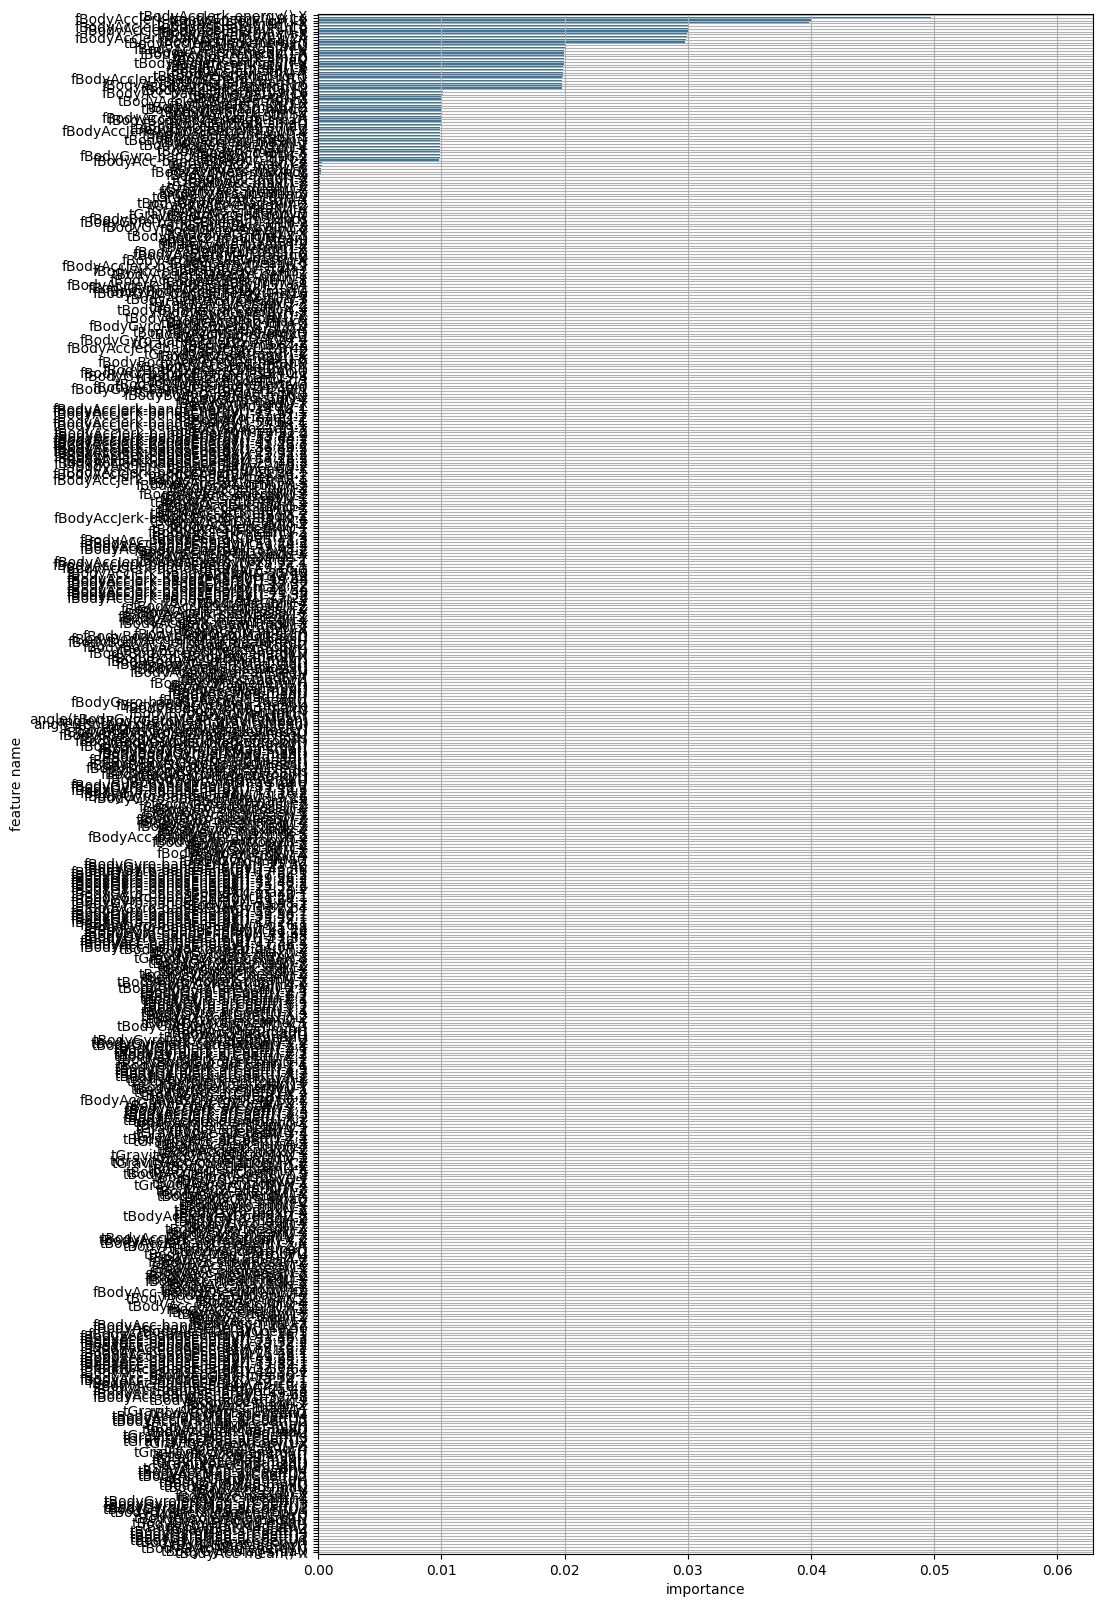

In [ ]:
r_dyn = plot_feature_importance(model.feature_importances_, list(x_train), False)
r_dyn

* 상위 변수 선정

In [ ]:
dyn_top_5 = r_dyn['feature_name'].head(5).tolist()
dyn_top_5

['tBodyAccJerk-energy()-X',
 'fBodyAccJerk-bandsEnergy()-9,16',
 'tBodyAccJerk-iqr()-X',
 'tBodyAccJerk-mad()-X',
 'fBodyAccJerk-bandsEnergy()-1,16']

* 데이터 탐색하기

In [ ]:
temp = x.copy()
temp['is_dynamic'] = is_dynamic
target = 'is_dynamic'

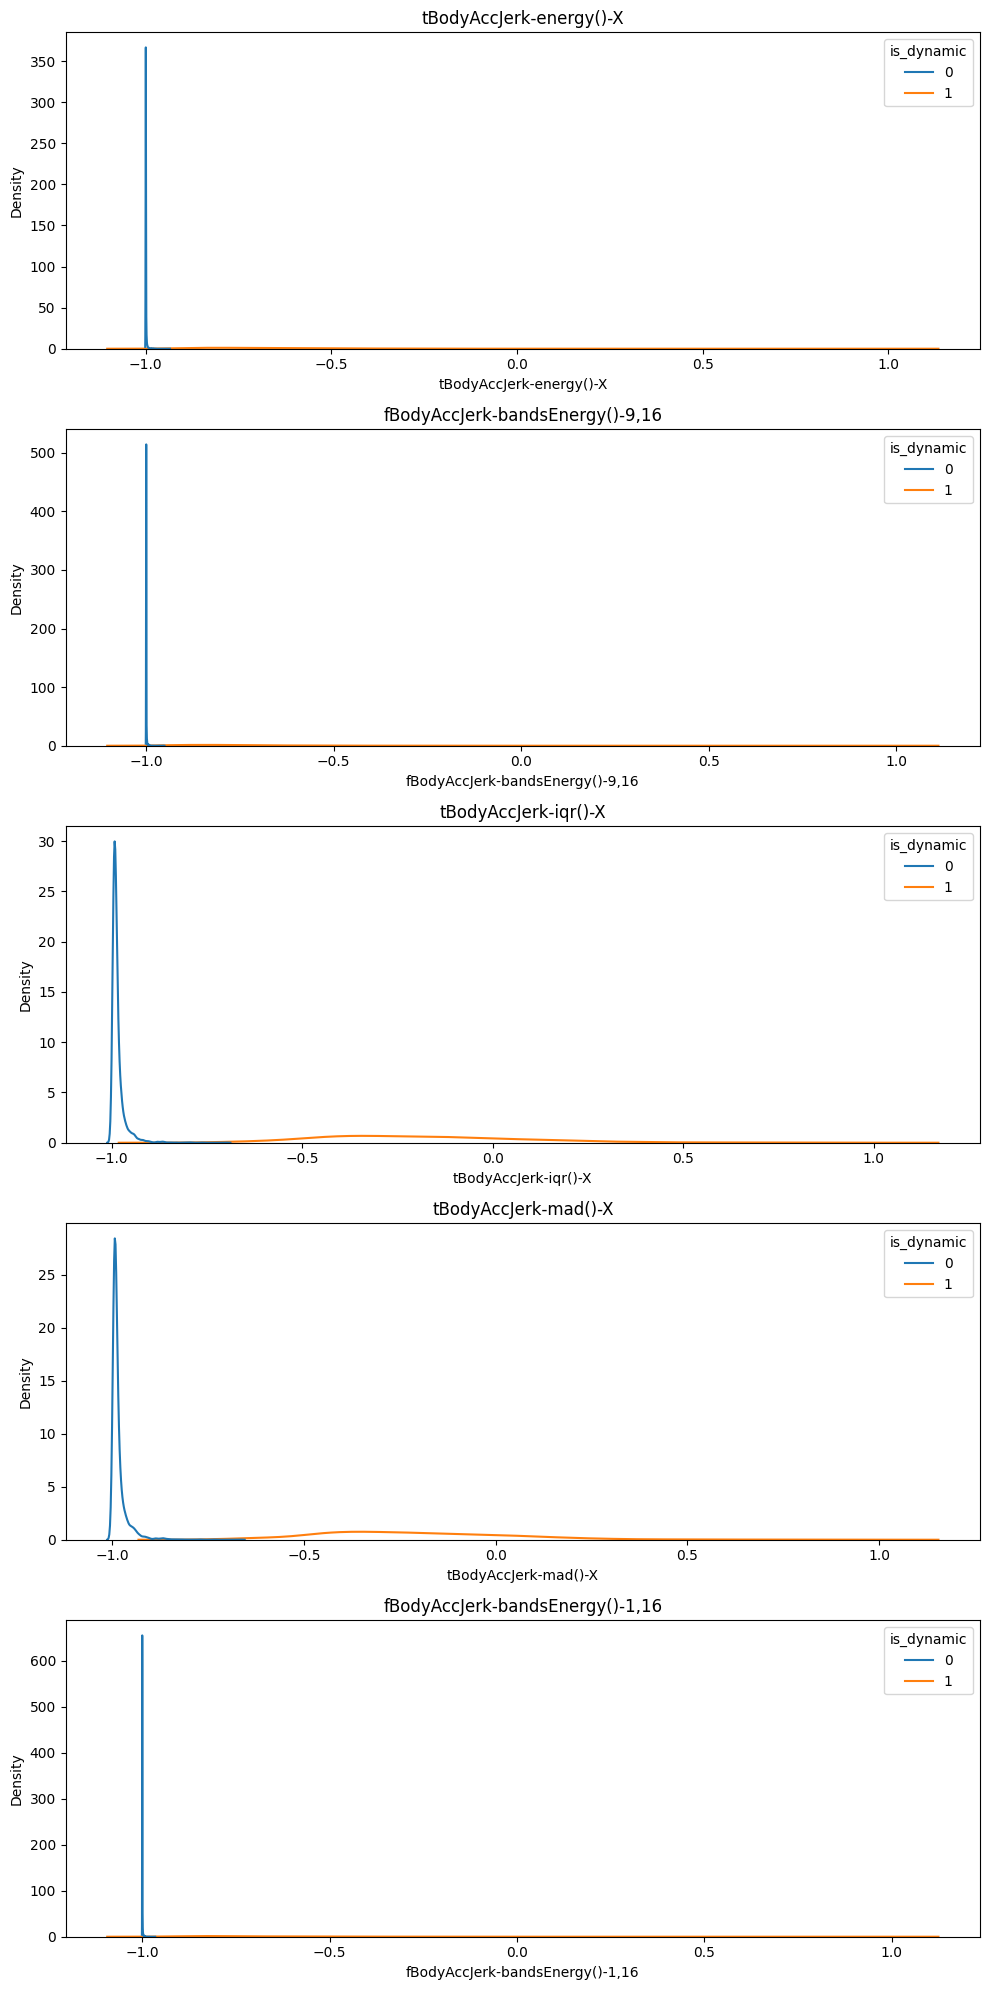

In [ ]:
# dyn_top_5 리스트에 있는 피처들을 자동으로 순회하면서 시각화
plt.figure(figsize=(10, 20))  # 그래프 크기 설정

for i, feature in enumerate(dyn_top_5):
    plt.subplot(5, 1, i+1)  # 5개의 subplot 생성
    sns.kdeplot(x=feature, data=temp, hue='is_dynamic')
    plt.title(f'{feature}')  # 피처 이름을 제목으로 표시

plt.tight_layout()  # 그래프 간격 자동 조정
plt.show()

In [ ]:
# 값이 어떻게 되어 있는지 확인
value_counts = temp['fBodyAccJerk-bandsEnergy()-1,24'].value_counts()
value_counts.head()

,count
"fBodyAccJerk-bandsEnergy()-1,24",
-0.999968,4
-0.999981,3
-0.999982,3
-0.999956,3
-0.999962,3


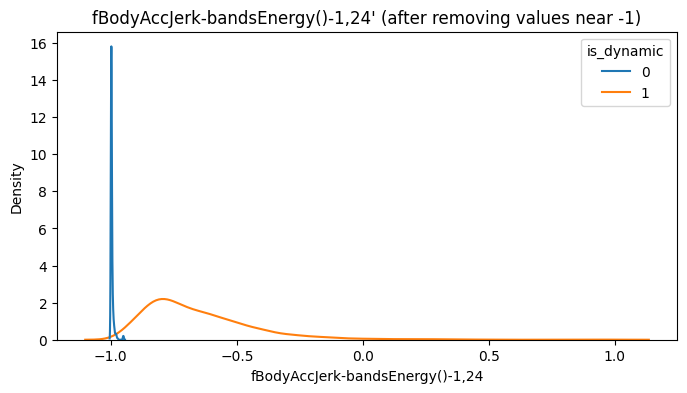

In [ ]:
filtered_train_df = temp[~temp['fBodyAccJerk-bandsEnergy()-1,24'].between(-1, -0.999)]

# -1 근처에 있는 값 제거 후 시각화 진행
plt.figure(figsize=(8, 4))
sns.kdeplot(data=filtered_train_df, x='fBodyAccJerk-bandsEnergy()-1,24', hue='is_dynamic')
plt.title("fBodyAccJerk-bandsEnergy()-1,24' (after removing values near -1)")
plt.xlabel('fBodyAccJerk-bandsEnergy()-1,24')
plt.ylabel('Density')
plt.show()

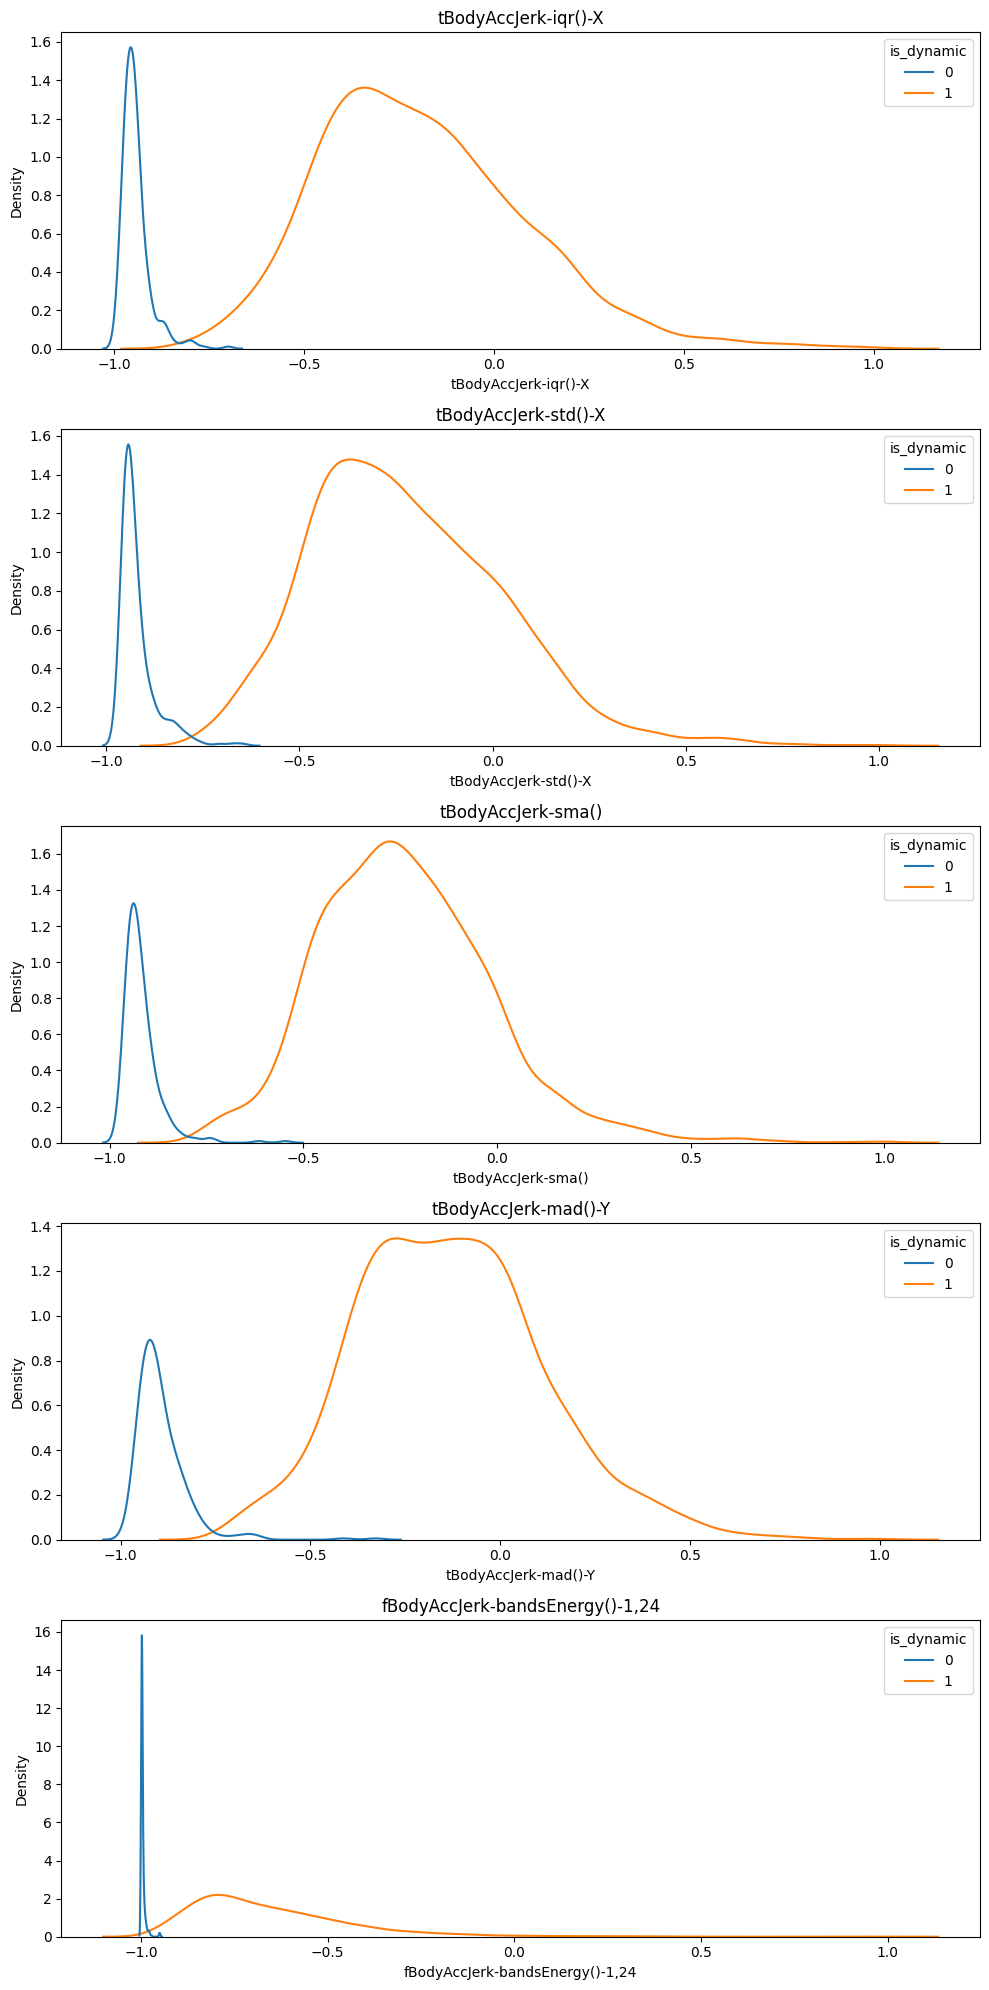

In [51]:
def visualize_features_after_filtering(df, features, hue_column):
    filtered_df = df.copy()  # 원본 데이터프레임 복사

    # 각 피처에서 -1과 -0.999 사이의 값 제거
    for feature in features:
        if df[feature].dtype != 'object':  # 숫자형 변수에만 적용
            filtered_df = filtered_df[~filtered_df[feature].between(-1, -0.999)]

    # 시각화
    plt.figure(figsize=(10, 20))  # 그래프 크기 설정

    for i, feature in enumerate(features):
        plt.subplot(5, 1, i+1)  # 5개의 subplot 생성
        sns.kdeplot(x=feature, data=filtered_df, hue=hue_column)
        plt.title(f'{feature}')  # 피처 이름을 제목으로 표시

    plt.tight_layout()  # 그래프 간격 자동 조정
    plt.show()

# 함수 호출 예시
visualize_features_after_filtering(temp, dyn_top_5, 'is_dynamic')

## 5.저장하기

#### 1) 이름변경

In [ ]:
r0.rename(columns={'feature_importance':'fi_all'}, inplace=True)
r_dyn.rename(columns={'feature_importance':'fi_dynamic'}, inplace=True)

#### 2) 합치기

In [ ]:
result = pd.merge(features, r0)
result = pd.merge(result, r_dyn)
result.head()

,sensor,agg,axis,feature_name,fi_all,fi_dynamic
0,tBodyAcc,mean(),X,tBodyAcc-mean()-X,0.000288,0.000000
1,tBodyAcc,mean(),Y,tBodyAcc-mean()-Y,0.000578,0.000000
2,tBodyAcc,mean(),Z,tBodyAcc-mean()-Z,0.000164,0.000078
3,tBodyAcc,std(),X,tBodyAcc-std()-X,0.005482,0.010014
4,tBodyAcc,std(),Y,tBodyAcc-std()-Y,0.000310,0.000000


### (2) 저장하기
* joblib.dump를 이용하시오.
* 저장할 파일의 확장자는 보통 .pkl 입니다.

In [ ]:
import joblib

joblib.dump(result, path + 'fi_analysis.pkl')

['/content/drive/MyDrive/project3/fi_analysis.pkl']